In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import gc
import traceback

# xsuite
import xtrack as xt
import xmask as xm
import xfields as xf
import xpart as xp
import xobjects as xo


# BBStudies
import sys
sys.path.append('/Users/pbelanger/ABPLocal/BBStudies')
sys.path.append('/home/phbelang/abp/BBStudies')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.Progress as pbar
import BBStudies.Tracking.InteractionPoint as inp
import BBStudies.Physics.Detuning as tune
import BBStudies.Plotting.BBPlots as bbplt
import BBStudies.Physics.Base as phys
import BBStudies.Physics.Constants as cst

# JOB imports
import importlib
sys.path.append('../../')
main_002 = importlib.import_module('Jobs.002_user_specific_tasks.main')
main = importlib.import_module('Jobs.003_particle_dist_and_track.main')







tracking_path = 'zfruits/BBB_Signature/FULL/'
tracked   = xPlus.Tracking_Interface.from_parquet(tracking_path ,partition_name='CHUNK')

data_path = 'zfruits/BBB_Signature/DATA/'
data      = xPlus.Tracking_Interface.from_parquet(data_path,partition_name='BUNCH')
_cpt      = xPlus.Tracking_Interface.from_parquet(data_path.replace('DATA','CHECKPOINTS'),partition_name='BUNCH')
data._checkpoint = _cpt._checkpoint



---
# Finding lost particles
---

In [2]:
coll_x = 2.602e-3/2
coll_y = 1.86e-3/2
coll_s = 2.189e-3/2


def lost_condition(x_min,y_min,skew_min,x_max,y_max,skew_max):
    # y_fun_skew = lambda _x: np.tan(np.deg2rad(skew_angle))*_x + coll_s/np.cos(np.deg2rad(180-skew_angle))
    # np.abs(y)>y_fun_skew(np.abs(x)))
    return (np.abs(x_min)>coll_x)|(np.abs(y_min)>coll_y)|(np.abs(x_max)>coll_x)|(np.abs(y_max)>coll_y) |(np.abs(skew_max)>coll_s) |(np.abs(skew_min)>coll_s)

# Intensity = {}
# survived  = {}



_lost  = lost_condition(tracked.data.x_min,tracked.data.y_min,tracked.data.skew_min,tracked.data.x_max,tracked.data.y_max,tracked.data.skew_max)
idx_lost     = tracked.data.index[_lost]
idx_survived = tracked.data.index[~_lost]


# New columns
try:
    tracked.data.insert(0,'beyond_coll',False)
    tracked.data.insert(0,'lost',False)
except:
    tracked.data.loc[:,'beyond_coll'] = False
    tracked.data.loc[:,'lost'] = False



tracked.data.loc[idx_lost,'beyond_coll'] = True
tracked.data.loc[:,'lost'] = tracked.data.groupby('particle').beyond_coll.cumsum().astype(bool)

Intensity= tracked.data[~tracked.data.lost].groupby('start_at_turn').count().lost
survived  = tracked.data[~tracked.data.lost].groupby('start_at_turn').get_group(tracked.data.start_at_turn.max()).particle


AttributeError: 'NoneType' object has no attribute 'x_min'

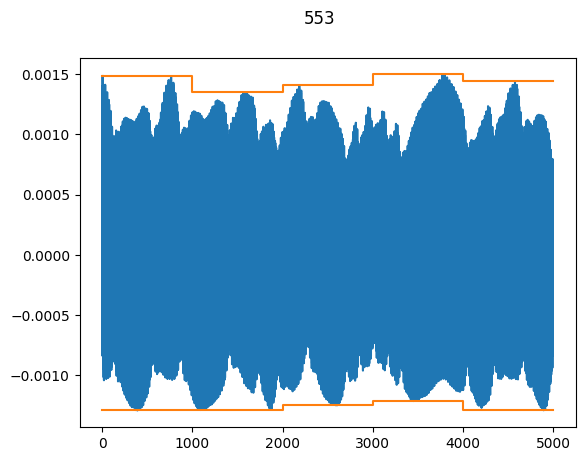

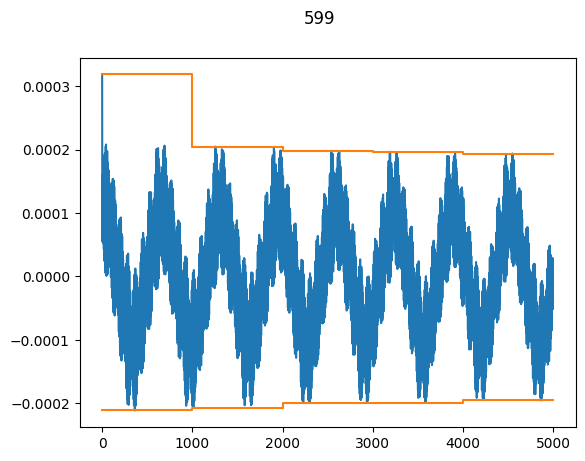

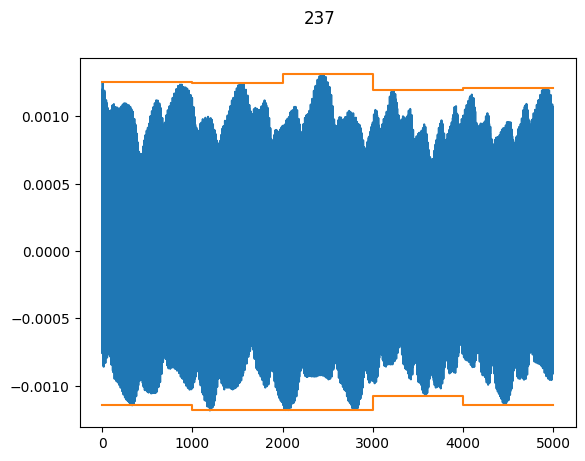

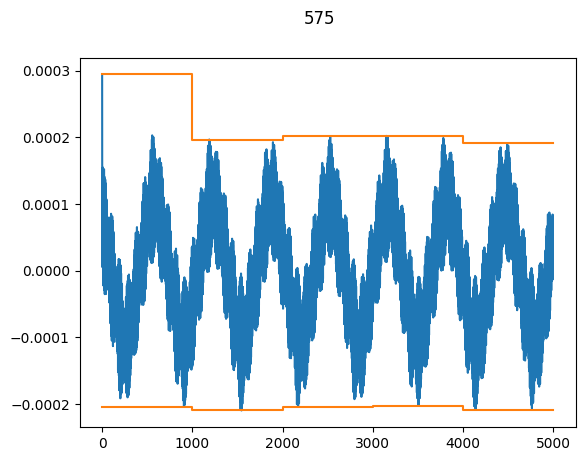

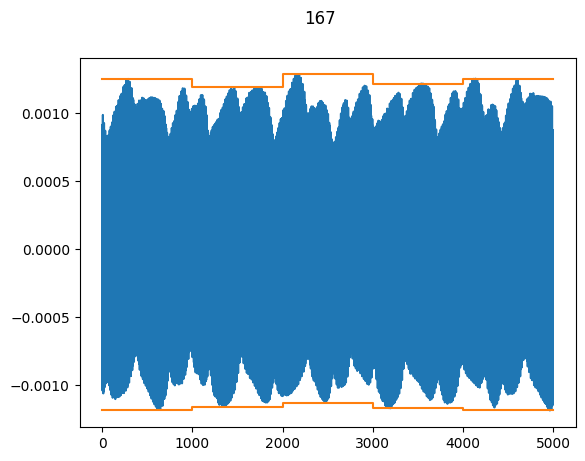

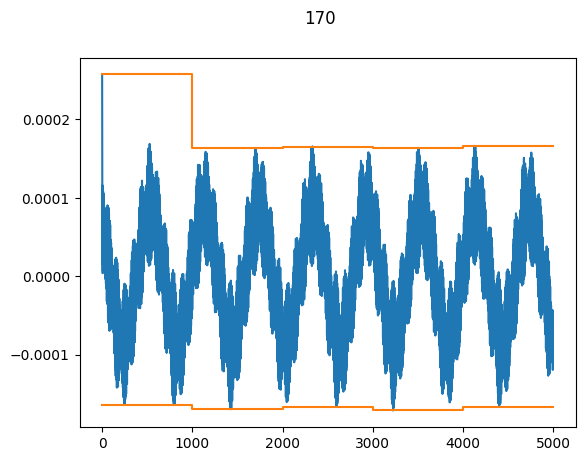

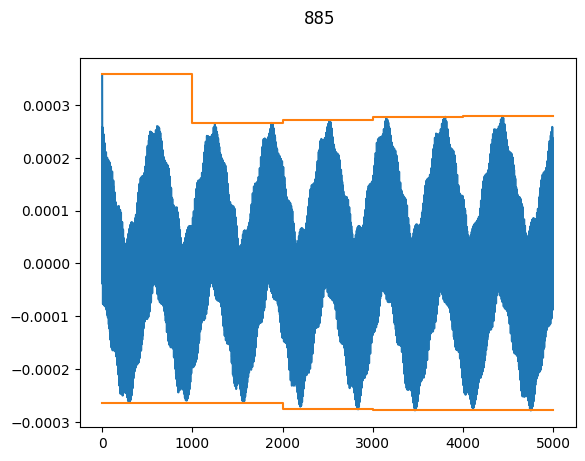

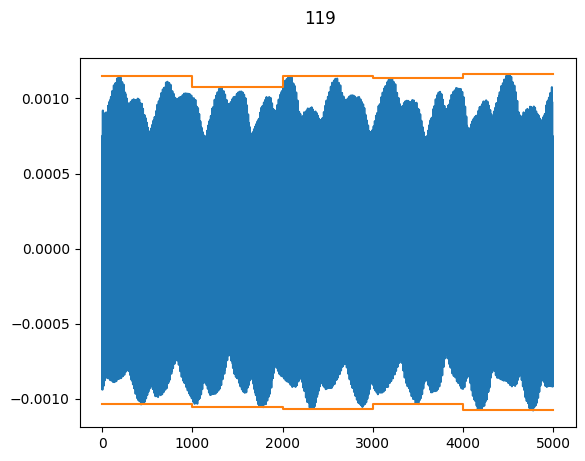

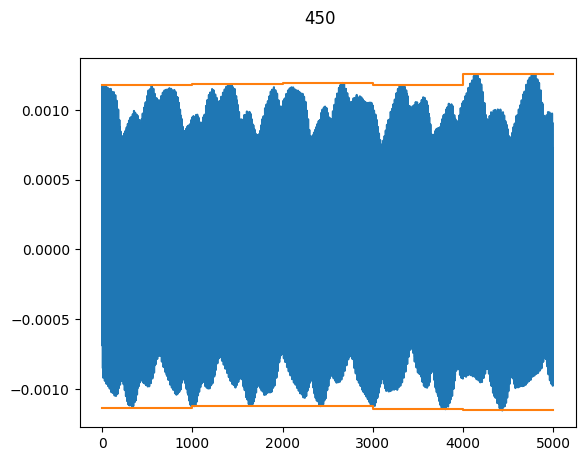

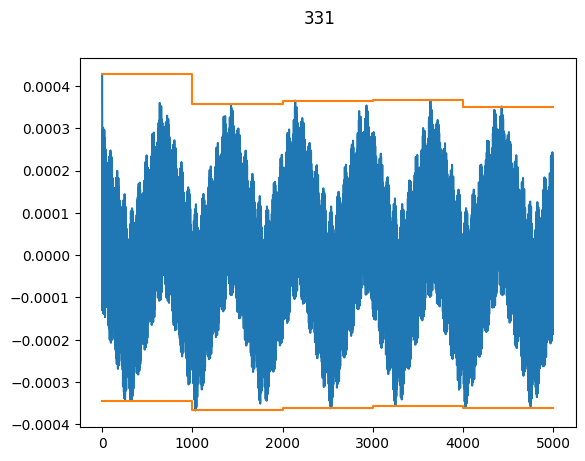

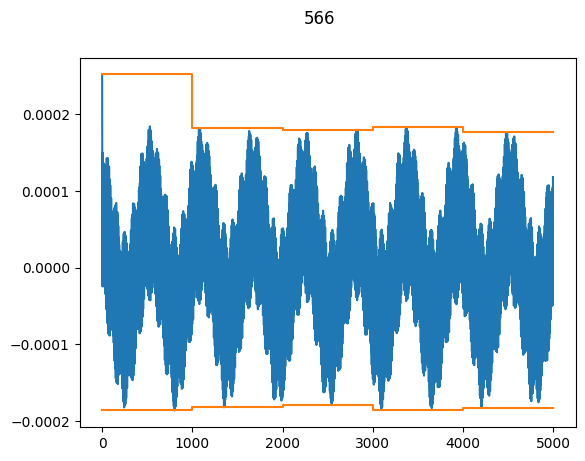

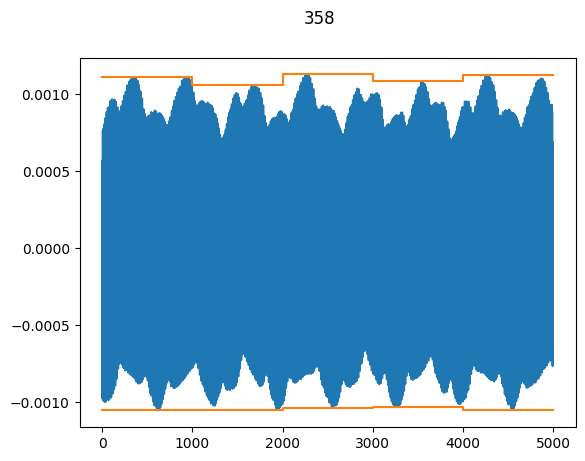

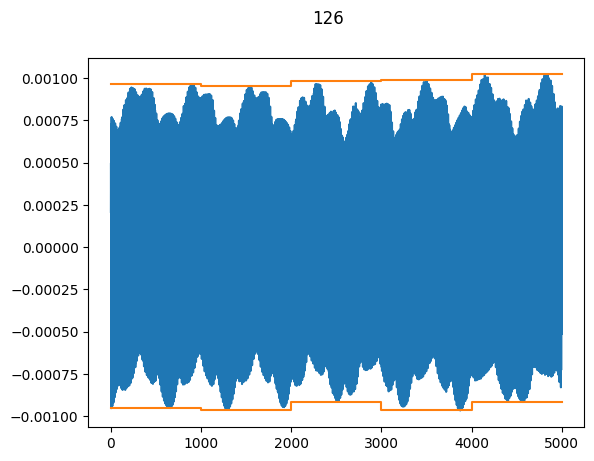

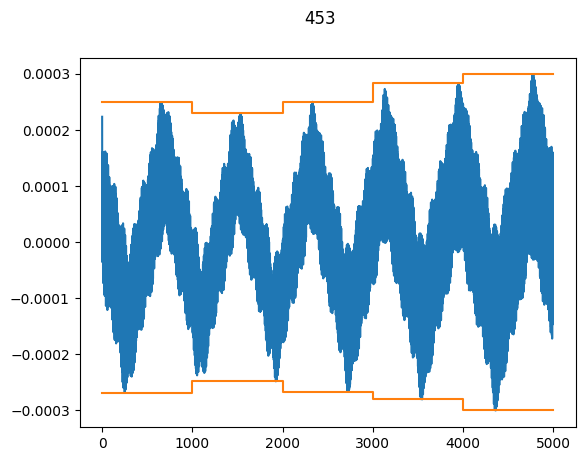

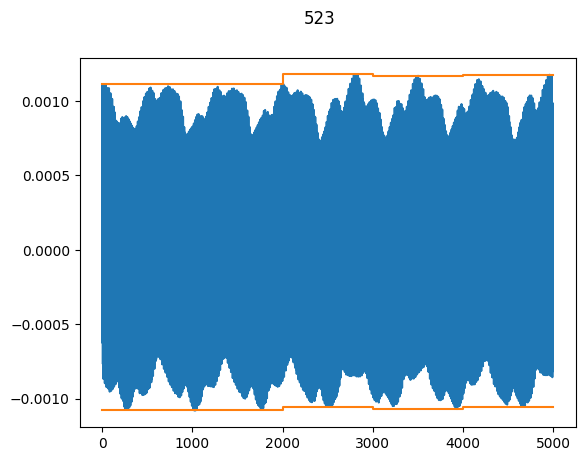

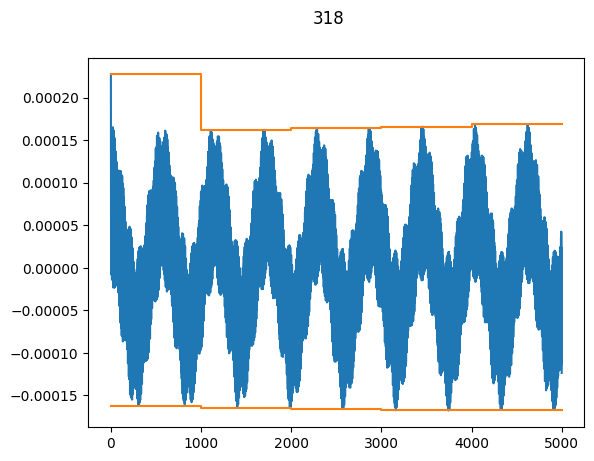

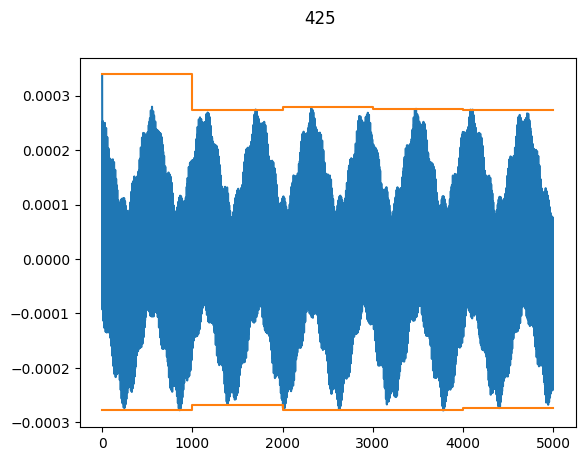

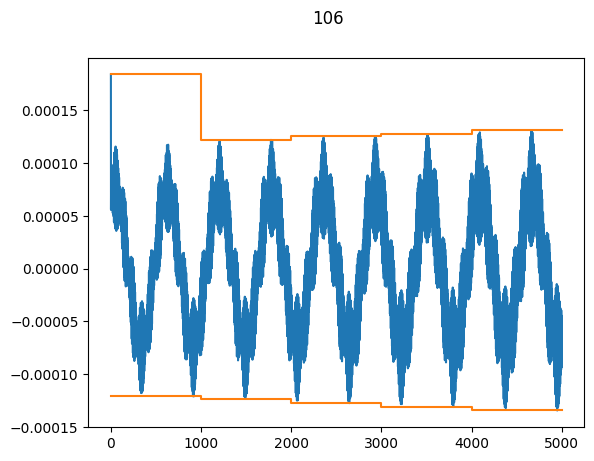

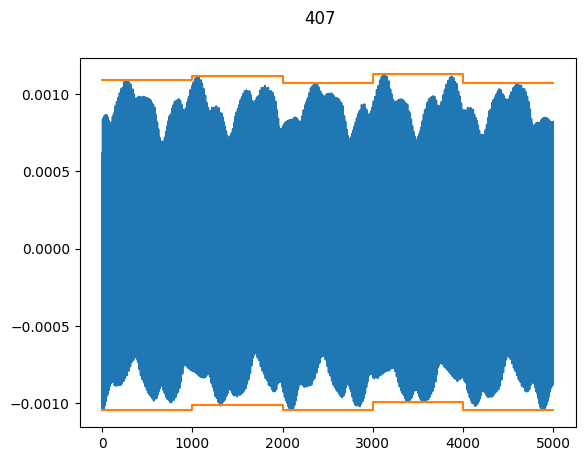

In [2]:


worst_particles = data.data.groupby('particle').apply(lambda part: np.max(part.x_max)-np.min(part.x_max)).sort_values(ascending=False).index

for part_ID in worst_particles[1:20]:
# for part_ID in np.arange(10,20):
    df = tracked.df.groupby('particle').get_group(part_ID)
    calc = data.data.groupby('particle').get_group(part_ID)

    plt.figure()
    plt.suptitle(part_ID)
    plt.plot(df.turn,df.x,'-')
    plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_min) + [np.nan],'-',where='post')
    plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_max) + [np.nan],'-',where='post',color='C1')



In [10]:
tracked.df[tracked.df.state != 0].groupby('particle').get_group(575).turn[:]

575000        0
575001        1
575002        2
575003        3
575004        4
           ... 
5116275    2995
5116276    2996
5116277    2997
5116278    2998
5116279    2999
Name: turn, Length: 5500, dtype: int64

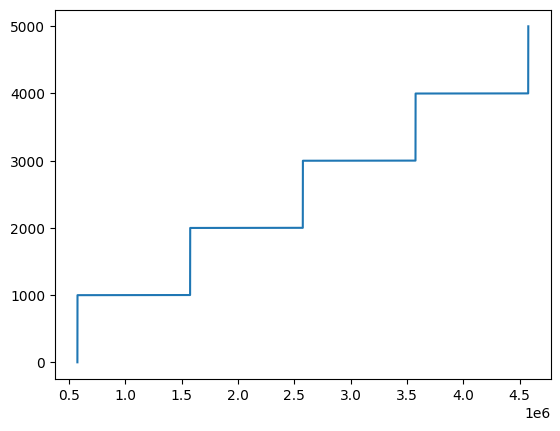

In [3]:
plt.figure()
plt.plot(tracked.df.groupby('particle').get_group(575).turn)

In [4]:
data.data

,BUNCH,Chunk ID,particle,state,start_at_turn,stop_at_turn,x_min,x_max,y_min,y_max,skew_min,skew_max,px_min,px_max,py_min,py_max,Qx,Qy,Qzeta
0,224,0,0,1,0,1000,-0.000970,0.001046,-0.000303,0.000285,0.000579,-0.000577,0.000013,-0.000013,-0.000004,0.000003,0.312528,0.312453,0.001374
1,224,0,1,1,0,1000,-0.000217,0.000221,-0.000377,0.000376,0.000406,-0.000402,0.000003,-0.000003,-0.000005,0.000005,0.304328,0.317406,0.001664
2,224,0,2,1,0,1000,-0.000264,0.000271,-0.000096,0.000095,0.000211,-0.000216,0.000003,-0.000003,-0.000001,0.000001,0.302657,0.311400,0.001838
3,224,0,3,1,0,1000,-0.000704,0.000730,-0.000237,0.000226,0.000517,-0.000512,0.000009,-0.000010,-0.000003,0.000003,0.308046,0.313525,0.001797
4,224,0,4,1,0,1000,-0.000566,0.000573,-0.000263,0.000253,0.000487,-0.000494,0.000007,-0.000008,-0.000004,0.000003,0.307215,0.315089,0.001761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,224,4,995,1,4000,5000,-0.000188,0.000192,-0.000302,0.000304,0.000328,-0.000328,0.000002,-0.000003,-0.000004,0.000004,0.001516,0.318011,0.001563
4996,224,4,996,1,4000,5000,-0.000593,0.000604,-0.000268,0.000255,0.000504,-0.000503,0.000007,-0.000008,-0.000003,0.000003,0.306896,0.314641,0.001582
4997,224,4,997,1,4000,5000,-0.000323,0.000335,-0.000330,0.000327,0.000427,-0.000430,0.000004,-0.000004,-0.000004,0.000005,0.303430,0.315088,0.001798
4998,224,4,998,1,4000,5000,-0.000268,0.000273,-0.000312,0.000309,0.000376,-0.000384,0.000004,-0.000004,-0.000004,0.000004,0.303159,0.315083,0.001725


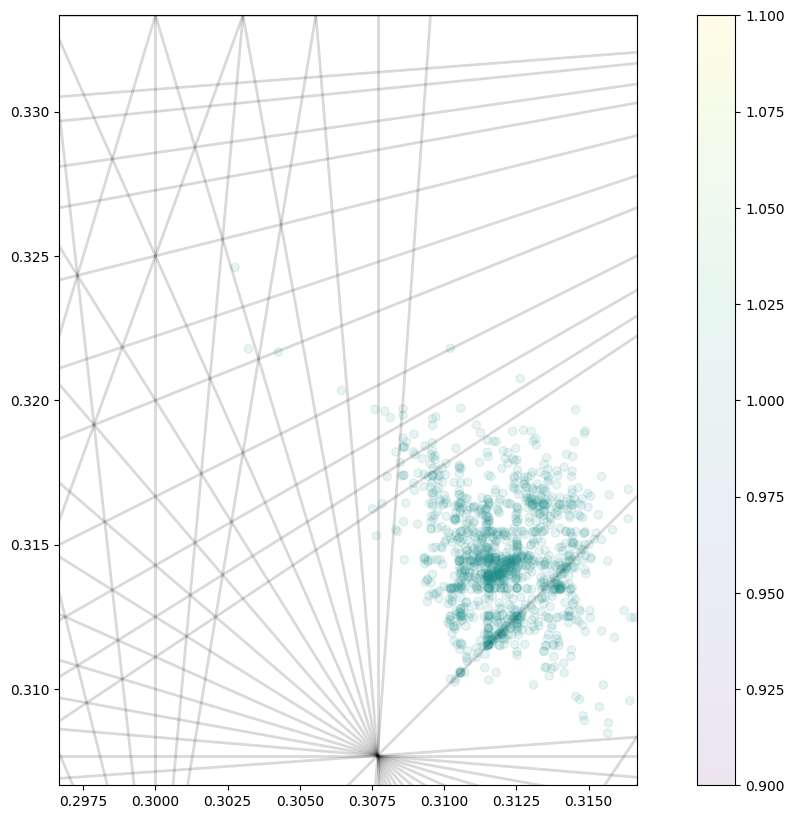

In [44]:

# chosen = trk0.coord_sig.particle.unique()
chosen = data.data.index
# chosen = (tracked.data.groupby('start_at_turn').get_group(14400).set_index('particle').lost)
# chosen = trk0.coord_sig[trk0.coord_sig.x_sig**2+trk0.coord_sig.y_sig**2<1**2].particle.unique()
# chosen = trk0.coord_sig[trk0.coord_sig.x_sig**2+trk0.coord_sig.px_sig**2<2**2].particle.unique()
# chosen = trk0.coord_sig[trk0.coord_sig.y_sig**2+trk0.coord_sig.py_sig**2<4].particle.unique()

plt.figure(figsize=(10,10))

# TEMPLATE FP PLT
#============================
window = 0.02
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-4*window/6,Qx_0+2*window/6]
Qy_lim    = [Qy_0-4*window/6,Qy_0+4*window/6]


bbplt.workingDiagram(order=15,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [0,0],alpha=0.15,color='k',lw=2)

# plt.plot(tracked.tunes.Qx.loc[chosen],tracked.tunes.Qy.loc[chosen],'.',alpha=0.1,color='C0')
# plt.scatter(tracked.tunes.Qx.loc[chosen],tracked.tunes.Qy.loc[chosen],c=trk0.coord_sig.set_index('particle').loc[chosen,'x_sig'],alpha=0.3)
plt.scatter(data.data.Qx.loc[chosen],data.data.Qy.loc[chosen],c=tracked.data.groupby('start_at_turn').get_group(14400).set_index('particle').loc[chosen,'lost'],alpha=0.1)
plt.colorbar()

# h1, = plt.plot([0],[0],'P',color='C3',alpha=0.8)
plt.axis('square')
plt.xlim(np.array(Qx_lim));
plt.ylim(np.array(Qy_lim));
#==============================




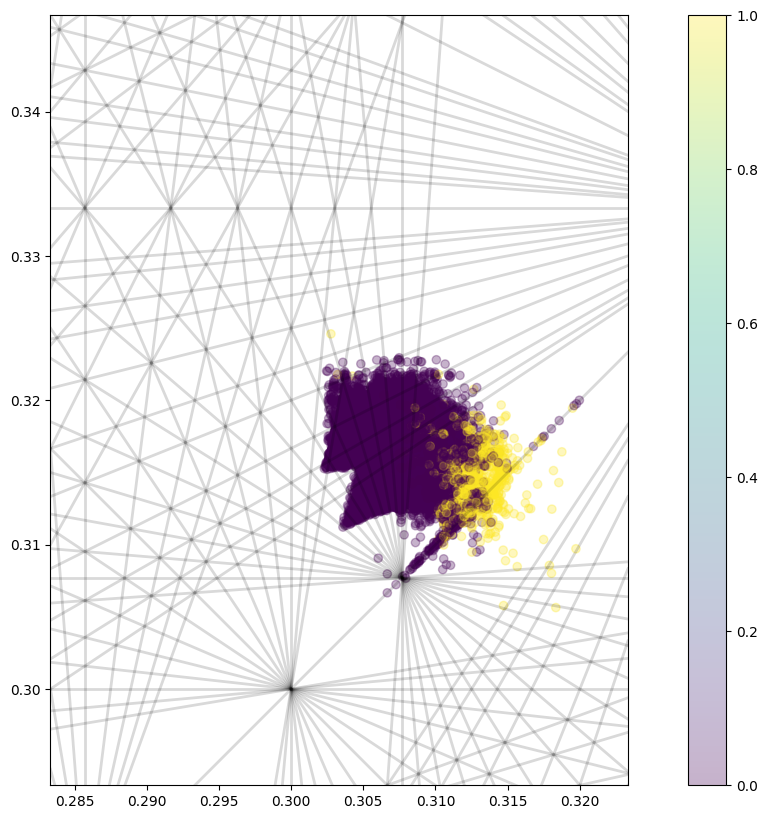

In [26]:

chosen = trk0.coord_sig.particle.unique()
# chosen = trk0.coord_sig[trk0.coord_sig.x_sig**2+trk0.coord_sig.y_sig**2<1**2].particle.unique()
# chosen = trk0.coord_sig[trk0.coord_sig.x_sig**2+trk0.coord_sig.px_sig**2<2**2].particle.unique()
# chosen = trk0.coord_sig[trk0.coord_sig.y_sig**2+trk0.coord_sig.py_sig**2<4].particle.unique()

plt.figure(figsize=(10,10))

# TEMPLATE FP PLT
#============================
window = 0.04
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-4*window/6,Qx_0+2*window/6]
Qy_lim    = [Qy_0-4*window/6,Qy_0+4*window/6]


bbplt.workingDiagram(order=15,Qx_range=Qx_lim,Qy_range = Qy_lim,offset = [0,0],alpha=0.15,color='k',lw=2)

# plt.plot(tracked.tunes.Qx.loc[chosen],tracked.tunes.Qy.loc[chosen],'.',alpha=0.1,color='C0')
plt.scatter(tracked.tunes_n.Qx.loc[chosen],tracked.tunes_n.Qy.loc[chosen],c=tracked.data.groupby('start_at_turn').get_group(14400).set_index('particle').loc[chosen,'lost'],alpha=0.3)
plt.colorbar()

# h1, = plt.plot([0],[0],'P',color='C3',alpha=0.8)
plt.axis('square')
plt.xlim(np.array(Qx_lim));
plt.ylim(np.array(Qy_lim));
#==============================


